# 构建人工神经网络

人工神经网络（英语：artificial neural network，ANNs）又称类神经网络，简称神经网络（neural network，NNs），在机器学习和认知科学领域，是一种模仿生物神经网络（动物的中枢神经系统，特别是大脑）的结构和功能的数学模型或计算模型，用于对函数进行估计或近似。与人类大脑的神经元相互连接类似，人工神经网络在网络的各个层中也有神经元相互连接。

相比于脉冲神经网络，人工神经网络中的神经元更为简化，不具有自身动力学。神经元之间传递的信息也不是0、1离散化的动作电位，而是连续的浮点数，可以被理解为在一个时间步内该神经元的发放率。虽然人工神经网络最初是受生物脑启发而来，也可以表现出一些生物脑的性质，但是我们主要使用它作为一种强大的模型解决具体问题，而不用纠结它各部分和生物的对应。

<center>
    <img src="../_static/artificial-neural-network-tutorial1.png" alt="bnn" />
</center>
<center>
    <img src="../_static/artificial-neural-network-tutorial2.png" alt="ann" />
</center>

## 人工神经网络架构
人工神经网络的神经元分布于不同的层，信息逐层前向传播。这些层可以分为3类：
- 输入层：人工神经网路的第一层是输入层，它接收输入并将其传递给隐藏层。
- 隐藏层：隐藏层对输入层传递来的信息进行各种计算和特征提取。通常，会有不止一个隐藏层，信息依次通过所有隐藏层进行计算。
- 输出层：最后，输出层接收隐藏层的信息进行计算，提供最终结果。

<center>
    <img src="../_static/artificial-neural-network-tutorial3.png" alt="ann2" />
</center>

人工神经网络根据计算不同有很多种类的层，其中最简单的层为线性层。线性层接收输入后，会计算输入的加权和，再加上一个偏差值。用公式可以表示为：
$$
\sum_{\mathrm{i=1}}^{\mathrm{n}}\mathrm{W_i}*\mathrm{X_i}+\mathrm{b}。\tag{1}
$$
这样的点积、求和都是线性运算。如果添加更多的层，但只使用线性操作，那么添加层将没有任何效果，通过交换律和结合律都可以等效为一层单一的线性变换。因此，需要通过添加非线性的**激活函数**，增加模型的表现力。可以理解为，通过激活函数判断神经元是否被激活，只有被激活神经元才有（非0）输出。这和生物神经元是类似的。激活函数类型多种多样，可以根据任务效果选用。在本教程的神经网络实现中，我们将使用ReLU（整流线性函数）和Softmax（归一化指数函数）激活函数，在下文中再详细叙述。

## 人工神经网络的工作流
人工神经网络是数据驱动的统计模型。我们训练模型解决问题，不是明确地编写规则，而是提供训练数据，使模型学会解决问题的方法。

具体而言，就是提供数据集，规定模型输入输出的对应关系，运行模型得到模型目前的输出，用**损失函数**计算当前输出和正确输出的差异。然后通过**反向传播**的方法，逐层对参数（主要是$W$和$b$）求偏导数，获得参数优化的大小和方向。然后用**优化器**进行参数优化，使模型的输出和数据集给出的标准输出更为相近。


# 构建你的第一个人工神经网络
下面我们用`brainstate`，写代码构建一个三层的多层感知机（Multilayer Perceptron, MLP），来完成一个手写数字识别（MNIST）的任务，作为示例。

我们将手写数字的图片输入构建好的多层感知机中，令多层感知机输出这张图片写的是哪一个数字。

<center>
    <img src="../_static/artificial-neural-network-tutorial5.jpg" alt="mnist mlp" />
</center>


In [1]:
import jax.numpy as jnp
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt

import brainstate
from braintools.metric import softmax_cross_entropy_with_integer_labels

In [2]:
brainstate.__version__

'0.1.0'

## 数据集准备
首先准备数据集。数据集提供了许多组对应的“输入-输出”样本，在这个任务中就是，手写数字图片和对应数字是多少的标签。

数据集可以分为训练集和测试集（二者的样本没有交集），在训练集上训练模型，调整模型的参数；在测试集上测试模型的训练效果，此时模型参数不更新。

In [3]:
dataset = load_dataset('mnist')
X_train = np.array(np.stack(dataset['train']['image']), dtype=np.uint8)
X_test = np.array(np.stack(dataset['test']['image']), dtype=np.uint8)
X_train = (X_train > 0).astype(jnp.float32)
X_test = (X_test > 0).astype(jnp.float32)
Y_train = np.array(dataset['train']['label'], dtype=np.int32)
Y_test = np.array(dataset['test']['label'], dtype=np.int32)

MNIST训练集有60000个样本，测试集有10000个样本。每个样本输入就是$28 \times 28$的单通道图像，输出是一位标签值。

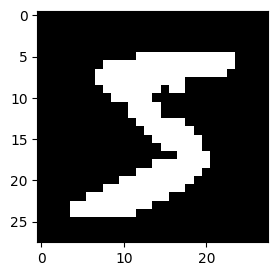

5


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [4]:
plt.figure(figsize=(3, 3))
plt.imshow(X_train[0], cmap='gray')
plt.show()
print(Y_train[0])
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

为了方便训练，我们需要将数据集包装为`Dataset`类，统一进行一些处理。

In [5]:
class Dataset:
    def __init__(self, X, Y, batch_size, shuffle=True):
        self.X = X
        self.Y = Y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(X))
        self.current_index = 0
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __iter__(self):
        self.current_index = 0
        if self.shuffle:
            np.random.shuffle(self.indices)
        return self

    def __next__(self):
        # Check if all samples have been processed
        if self.current_index >= len(self.X):
            raise StopIteration

        # Define the start and end of the current batch
        start = self.current_index
        end = start + self.batch_size
        if end > len(self.X):
            end = len(self.X)
        
        # Update current index
        self.current_index = end

        # Select batch samples
        batch_indices = self.indices[start:end]
        batch_X = self.X[batch_indices]
        batch_Y = self.Y[batch_indices]

        # Ensure batch has consistent shape
        if batch_X.ndim == 1:
            batch_X = np.expand_dims(batch_X, axis=0)

        return batch_X, batch_Y

在训练时，我们一般会将数据划分为批（batch），输入模型。模型根据一个批次的所有样本计算损失，进行梯度回传优化参数。

因为如果将整个训练集输入模型，会需要过大的显存；如果只将一个训练样本输入模型训练，并行化不够会导致资源浪费、遍历完一个训练集用时过长，也会导致每次参数更新只包含一个样本点的信息，不利于在整个数据集上收敛。以批的形式输入是很好的权衡。测试集由于不需要更新参数，所以可以在显存允许的情况下，批的大小可以设置地更大一些。

训练集一般打乱顺序（`shuffle=True`），这样能尽量保证每次迭代训练集，每个批都有不同的样本组合，有利于模型在整个数据集上收敛。训练集不需要更新参数所以不用打乱。

In [6]:
# Initialize training and testing datasets
batch_size = 32
train_dataset = Dataset(X_train, Y_train, batch_size, shuffle=True)
test_dataset = Dataset(X_test, Y_test, batch_size, shuffle=False)

## 模型结构设置

经典的多层感知机具有3个线性层，一个输入层，一个隐藏层，和一个输出层。

在定义每个线性层时，需要给出这一层的输入维数和输出维数。（这是非常好理解的，由公式（1），需要提供$W$的大小）

- 线性层只接受一维输入，因此我们要使用`flatten()`函数将二维图片展为一维。在这里，$28*28=784$就是第一个线性层输入的大小。
- 手写数字识别是十分类任务，对于多分类任务，一般要求模型的输出是一个十维的向量，每一维表示是这一维对应标签的概率是多少。因此，最后一个线性层的输出维是$10$。
- 隐层在自动提取特征，维数越多，提取的特征越多，表现力越强大。在这个简单的任务中，可以将隐藏层的维数设置为$784$和$10$之间的一个数，如果效果不好，就增加隐藏层维数。在其他更困难的任务中，可以增加隐藏层层数，并且使隐藏层维数超过模型输入和输出维。但一般隐藏层的维数要逐层增加，再逐层下降。
- 注意，相邻的层，上一层的输出维数，就是下一层的输入维数。

<center>
    <img src="../_static/artificial-neural-network-tutorial5.jpg" alt="mnist mlp" />
</center>

如前文所说，线性层之间需要加入激活函数，否则就相当于一个线性层。在这里，我们使用了ReLU（整流线性函数）激活函数将负值置为0，增加非线性。公式为：
$$
\text{ReLU}(x) = \max(0, x)\tag{2}
$$

<center>
    <img src="../_static/artificial-neural-network-tutorial4.png" alt="relu" />
</center>


In [7]:
# Define MLP model
class MLP(brainstate.nn.Module):
  def __init__(self, din, dhidden, dout):
    super().__init__()
    self.linear1 = brainstate.nn.Linear(din, dhidden)   # Define the first linear layer, input dimension is din, output dimension is dhidden       
    self.linear2 = brainstate.nn.Linear(dhidden, dhidden)   # Define the second linear layer, input dimension is dhidden, output dimension is dhidden
    self.linear3 = brainstate.nn.Linear(dhidden, dout)    # Define the third linear layer, input dimension is dhidden, output dimension is dout (10 classes for MNIST)
    self.flatten = brainstate.nn.Flatten(start_axis=1)   # Flatten images to 1D
    self.relu = brainstate.nn.ReLU()   # ReLU activation function

  def __call__(self, x):
    x = self.flatten(x)  # Flatten the input image from 2D to 1D
    x = self.linear1(x)  # Pass the flattened input through the first linear layer
    x = self.relu(x)      # Alternatively, you can use jax's ReLU function: x = jax.nn.relu(x)
    x = self.linear2(x)   # Pass the result through the second linear layer
    x = self.relu(x)      # Apply the ReLU activation function
    x = self.linear3(x)   # Pass the result through the third linear layer to get the final output

    return x

In [8]:
# Initialize model with input, hidden, and output layer sizes
model = MLP(din=28*28, dhidden=512, dout=10)

## 模型优化

人工神经网络得到图片输入后，运行输出分类结果。我们需要将这个分类结果和标准答案进行对比，然后优化参数，让模型预测的类别概率尽可能接近真实类别。

### 损失函数

在这个过程中，用**损失函数**衡量分类结果和真实类别差异的大小。针对输出的不同含义，有多种多样的损失函数可以选择。这里我们使用多分类任务的常用损失函数交叉熵（cross entropy）函数。对于一个样本，交叉熵损失函数公式如下：

$$
Loss(y_i, \hat{y_i}) = - \sum_{i=1}^{N} y_i \log(\hat{y_i})\tag{3}
$$

其中，$\hat{y_i}$ 是模型预测的概率分布（所有类别的概率和为1），$y_i$ 是真实类别标签，使用 One-Hot 编码（只有正确类别对应的值为 1，其余为 0），$N$ 是类别的数量。如果模型正确预测（真实类别的概率接近 1），损失会非常小；反之，真实类别的概率接近 0 时，损失会非常大。

在此，我们给损失函数的输入模型输出值并不是概率值（没有控制所有类别的概率和为1），是因为`braintools.metric`中的损失函数`softmax_cross_entropy_with_integer_labels`会自动让模型的输出经过softmax（归一化指数函数）激活函数，将其转换为概率分布。公式如下：

$$
\sigma(\mathbf{z})_i = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}\tag{4}
$$

其中，$\mathbf{z}$ 是输入向量，$z_i$ 是输入向量中的第 $i$ 个元素，$K$ 是输入向量的维度。

同时，`softmax_cross_entropy_with_integer_labels`也可以将一维真实类别标签自动转为One-Hot 编码。

### 反向传播算法

**反向传播**（Backpropagation） 是神经网络训练过程中优化参数的关键算法。它的主要任务是根据损失函数的值，计算出模型中每个参数（主要是权重$W$和偏置$b$）的梯度。用这种方法推测模型预测的误差来源，用于优化参数。得到损失值后，反向传播利用链式法则，逐层计算损失函数对每个参数的偏导数。这些偏导数（梯度）描述了损失函数随着参数变化的方向和幅度，是优化的基础。

### 优化器
**优化器**（Optimizer） 是一种算法，决定得到梯度后，如何用其更新网络的参数（主要是权重和偏置），减少损失值。基本的更新公式是：
$$
w=w-\eta\cdot\frac{\partial L}{\partial w}\tag{5}
$$
其中$w$是参数，$\eta$是学习率，$\frac\partial L{\partial w}$是梯度。

有很多种类的优化器可供选择，在此我们选用的是常用的SGD（随机梯度下降）优化器。

在这里我们将模型的优化器实例化，并指定其更新的参数是哪些。

In [9]:
# Initialize optimizer and register model parameters
optimizer = brainstate.optim.SGD(lr = 1e-3)   # Initialize SGD optimizer with learning rate
optimizer.register_trainable_weights(model.states(brainstate.ParamState))   # Register parameters for optimization

## 模型训练&测试
在每一个训练数据批的迭代中，都有这样的训练流程：
- 将数据输入模型，得到输出
- 计算损失值
- 计算梯度
- 将梯度提供给优化器，优化器优化参数

In [10]:
# Training step function
@brainstate.compile.jit
def train_step(batch):
  x, y = batch
  # Define loss function
  def loss_fn():
    return softmax_cross_entropy_with_integer_labels(model(x), y).mean()
  
  # Compute gradients of the loss with respect to model parameters
  grads = brainstate.augment.grad(loss_fn, model.states(brainstate.ParamState))()
  optimizer.update(grads)   # Update parameters using optimizer

在每一个测试数据批的迭代中，测试流程无需计算梯度和优化参数，但可以选择计算正确率反映训练的效果：
- 将数据输入模型，得到输出
- 计算损失值
- 计算正确率

In [11]:
# Testing step function
@brainstate.compile.jit
def test_step(batch):
  x, y = batch
  y_pred = model(x)   # Perform forward pass
  loss = softmax_cross_entropy_with_integer_labels(y_pred, y).mean()   # Compute loss
  correct = (y_pred.argmax(1) == y).sum()   # Count correct predictions

  return {'loss': loss, 'correct': correct}

模型一般在同一个训练集上训练多次，每一次都分批迭代完整个训练集；可以每次或每几次在测试集上查看训练效果。

在下面这个例子中，随着训练集迭代次数的增加，训练损失值逐渐减小，测试正确率逐渐提高，说明我们成功地训练了一个多层感知机进行手写数字分类。

In [12]:
# Execute training and testing
total_steps = 20
for epoch in range(10):
  for step, batch in enumerate(train_dataset):
    train_step(batch)   # Perform training step for each batch

  # Calculate test loss and accuracy
  test_loss, correct = 0, 0
  for step_, test_ in enumerate(test_dataset):
    logs = test_step(test_)
    test_loss += logs['loss']
    correct += logs['correct']
    test_loss += logs['loss']
  test_loss = test_loss / (step_ + 1)
  test_accuracy = correct / len(X_test)
  print(f"epoch: {epoch}, test loss: {test_loss}, test accuracy: {test_accuracy}")

epoch: 0, test loss: 1.2870731353759766, test accuracy: 0.8459000587463379
epoch: 1, test loss: 0.8965848088264465, test accuracy: 0.8851000666618347
epoch: 2, test loss: 0.7595921754837036, test accuracy: 0.8992000222206116
epoch: 3, test loss: 0.6877797842025757, test accuracy: 0.9066000580787659
epoch: 4, test loss: 0.6413018703460693, test accuracy: 0.9117000699043274
epoch: 5, test loss: 0.6088062524795532, test accuracy: 0.914400041103363
epoch: 6, test loss: 0.5789325833320618, test accuracy: 0.9187000393867493
epoch: 7, test loss: 0.5573971271514893, test accuracy: 0.921000063419342
epoch: 8, test loss: 0.5350563526153564, test accuracy: 0.9230000376701355
epoch: 9, test loss: 0.5217731595039368, test accuracy: 0.9251000285148621
